# DSCI-598 Capstone
## Maryville University
### November - December 2023

## Data Visualisations and analysis notebook 
## by Alison Hawke

In [22]:
import numpy as np 
import pandas as pd 
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [2]:
train = pd.read_csv('/kaggle/input/forest-cover-type-prediction/train.csv', dtype = str)
test = pd.read_csv('/kaggle/input/forest-cover-type-prediction/test.csv', dtype = str)

# Colour palette
fc_pal = ['orchid', 'lightcoral', 'orange', 'gold', 'lightgreen', 'deepskyblue', 'cornflowerblue']

In [3]:
print('Training set shape', train.shape)
print('Test set shape', test.shape)

Training set shape (15120, 56)
Test set shape (565892, 55)


## Feature data fields in the provided Kaggle dataset:

* Elevation in meters
* Aspect in degrees azimuth
* Slope in degrees
* Horizontal_Distance_To_Hydrology dist to nearest surface water features
* Vertical_Distance_To_Hydrology dist to nearest surface water features
* Horizontal_Distance_To_Roadways dist to nearest roadway
* Hillshade_9am (0 to 255 index) hillshade index at 9am, summer solstice
* Hillshade_Noon (0 to 255 index) hillshade index at noon, summer solstice
* Hillshade_3pm (0 to 255 index) hillshade index at 3pm, summer solstice
* Horizontal_Distance_To_Fire_Points dist to nearest wildfire ignition points
* Wilderness_Area (4 binary columns, 0 = absent or 1 = present) wilderness area designation
* Soil_Type (40 binary columns, 0 = absent or 1 = present) soil type designation

These features are used to predict the following label:
* Cover_Type (7 types) Forest cover type designation

The seven forest cover types are:

* Spruce/Fir
* Lodgepole Pine
* Ponderosa Pine
* Cottonwood/Willow
* Aspen
* Douglas-fir
* Krummholz

The features Soil_Type and Wilderness_Area have been one-hot encoded in the provided data. 

In [4]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [5]:
df = train.drop(['Id'], axis = 1)
df.value_counts(['Cover_Type']).sort_index()

Cover_Type
1             2160
2             2160
3             2160
4             2160
5             2160
6             2160
7             2160
Name: count, dtype: int64

In [6]:
df.isnull().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


In [7]:
df.shape

(15120, 55)

# Numeric features 

In [44]:
# extract numeric features from train
num_features = train.iloc[:,1:11]

In [45]:
num_features.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
count,15120,15120,15120,15120,15120,15120,15120,15120,15120,15120
unique,1665,361,52,400,423,3250,176,141,247,2710
top,2830,45,11,0,0,150,226,225,143,618
freq,25,117,740,1590,1890,88,279,327,182,65


# Categorical features

In [48]:
# extract binary features from train
cat_features = train.iloc[:, 11:-1]

In [49]:
cat_features.describe()

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,15120,15120,15120,15120,15120,15120,15120,15120,15120,15120,...,15120,15120,15120,15120,15120,15120,15120,15120,15120,15120
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
freq,11523,14621,8771,10445,14765,14497,14158,14277,14955,14470,...,14788,14430,14504,15098,15018,15110,15086,14392,14463,14661


# Correlation between features

The correlation matrix displays which features are strongly correlated to each other, displaying a pairwise list.

From the output below, Hillshade_3pm and Hillshade_9am are strongly correlated, it could be useful to exclude one of these measurements as they are similar and therefore do not add much to the data. Hillshade also correlates with Slope and Aspect, which is logical.

Horizontal distance to roadways and firepoints (wildfire ignition points) are correlated, this could be because roads and wildfires are linked due to careless human activity.

Correlation scores above 0.6 are considered a good correlation, which are the following:

* Wilderness_Area4 and Elevation: 0.783651
* Hillshade_3pm and Hillshade_9am: 0.779965
* Vertical_Distance_To_Hydrology and Horizontal_Distance_To_Hydrology: 0.652142
* Aspect and Hillshade_3pm: 0.635022
* Hillshade_3pm and Hillshade_Noon: 0.614526
* Hillshade_Noon and Slope: 0.612613

None of the soil types are included in this list.

In [12]:
corrMatrix = df.corr()

corrAbs = corrMatrix.abs().unstack()
corrSorted = corrAbs.sort_values(ascending = False).drop_duplicates()

corrSorted.head(50)

Elevation                           Elevation                             1.000000
Wilderness_Area4                    Elevation                             0.783651
Hillshade_3pm                       Hillshade_9am                         0.779965
Vertical_Distance_To_Hydrology      Horizontal_Distance_To_Hydrology      0.652142
Aspect                              Hillshade_3pm                         0.635022
Hillshade_3pm                       Hillshade_Noon                        0.614526
Hillshade_Noon                      Slope                                 0.612613
Aspect                              Hillshade_9am                         0.593997
Horizontal_Distance_To_Roadways     Elevation                             0.578659
Wilderness_Area4                    Wilderness_Area3                      0.569200
Wilderness_Area1                    Soil_Type29                           0.546309
Horizontal_Distance_To_Roadways     Horizontal_Distance_To_Fire_Points    0.486386
Wild

# Attempt to reverse the one-hot encoding

While this was not sucessful in Kaggle, the idxmax method worked on a local notebook.

In [13]:
wilderness_temp = train[['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']]
wilderness_temp.describe()

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
count,15120,15120,15120,15120
unique,2,2,2,2
top,0,0,0,0
freq,11523,14621,8771,10445


In [14]:
#Use one of the following:
#wilderness_df = pd.from_dummies(wilderness_temp).rename(columns = {'': 'Wilderness_Area'})
#wilderness_df = temp.idxmax(axis = 1)

In [15]:
soil_temp = train[['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 
                      'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 
                      'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 
                      'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 
                      'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
                      'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29',
                      'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
                      'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
                      'Soil_Type40']]
soil_temp.describe()

,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,15120,15120,15120,15120,15120,15120,15120,15120,15120,15120,...,15120,15120,15120,15120,15120,15120,15120,15120,15120,15120
unique,2,2,2,2,2,2,1,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
freq,14765,14497,14158,14277,14955,14470,15120,15119,15110,12978,...,14788,14430,14504,15098,15018,15110,15086,14392,14463,14661


In [16]:
#Use one of the following:
#soil_df = pd.from_dummies(soil_temp).rename(columns = {'': 'Soil_Type'})
#soil_df = soil_temp.idxmax(axis = 1)

# Wilderness Areas

The Wilderness Areas are well-distributed in the test set:

* Area 1: 3597 records (0.2379 of the data set)
* Area 2: 5174 records (0.3422 of the data set)
* Area 3: 6439 records (0.4259 of the data set)
* Area 4: 4675 records (0.3092 of the data set)

Areas 4, 1, and 3 are in the top 20 most important features list, in descending order of importance.

# Soil Types

* Soil types 7 and 15 do not appear in the training data set. 
* Types 8 and 25 only occur once. 
* Types 9, 21, 27, 28, and 36 occur less than 20 times.

Types 10, 38, 3, 39, 4, 40, and 30 are in the top 20 most important features list, in descending order of importance.

# Visualisations

In [18]:
df = train.copy()

df['Cover_Type'] = df.Cover_Type.str.replace('1', 'Spruce/Fir')
df['Cover_Type'] = df.Cover_Type.str.replace('2', 'Lodgepole Pine')
df['Cover_Type'] = df.Cover_Type.str.replace('3', 'Ponderosa Pine')
df['Cover_Type'] = df.Cover_Type.str.replace('4', 'Cottonwood/Willow')
df['Cover_Type'] = df.Cover_Type.str.replace('5', 'Aspen')
df['Cover_Type'] = df.Cover_Type.str.replace('6', 'Douglas Fir')
df['Cover_Type'] = df.Cover_Type.str.replace('7', 'Krummholz')

In [19]:
cover_counts = df.Cover_Type.value_counts()
px.bar(x = cover_counts.index, y = cover_counts, color = cover_counts.index, title = 'Cover Type Count in training data')

The above graph shows that the training data has each of the seven cover types in equal amounts, making it an entirely balanced data set.

## Correlation plot

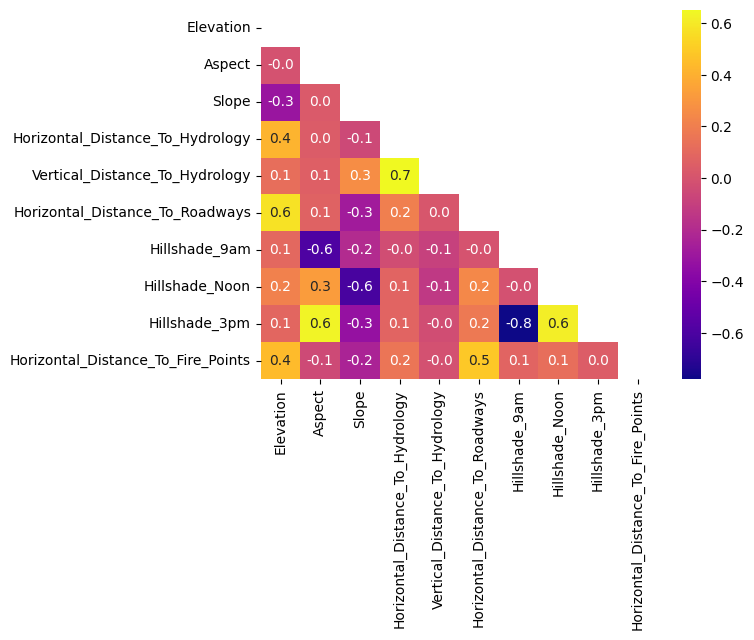

In [23]:
def show_corr_plot(df):
    corr = df[['Elevation', 'Aspect', 'Slope',
           'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
           'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
           'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']].corr()

    up = corr.where(np.tril(np.ones(corr.shape), k = -1).astype(bool))
    sns.heatmap(up, fmt = '.1f', annot = True, cmap = 'plasma')
    
show_corr_plot(df)

WHAT'S GOING ON HERE

# Distance and elevation

In [24]:
px.scatter(data_frame = df, x = 'Horizontal_Distance_To_Roadways', y = 'Elevation', color = 'Cover_Type', title = 'distance and elevation')

WHAT DOES THIS SHOW

# Histograms

In [55]:
wild_data, soil_data = cat_features.iloc[:,:4], cat_features.iloc[:,4:]

In [56]:
num_features.hist(figsize = (16,12), bins = 50)
plt.show()

ValueError: hist method requires numerical or datetime columns, nothing to plot.

In [57]:
# plot bg
sns.set_style("darkgrid", {'grid_color': '.1'})

# sum soil data, pass it as a series
soil_sum = pd.Series(soil_data.sum())
soil_sum.sort_values(ascending = False, inplace = True)

In [58]:
# plot bar
soil_sum.plot(kind='barh', figsize=(23,17), color='#a87539')
plt.gca().invert_yaxis()
plt.title('# of Observations of Soil Types', size=18)
plt.xlabel('# of Observation', size=16)
plt.ylabel('Soil Types', size=16)
plt.xticks(rotation='horizontal',size=14)
plt.yticks(size=14)

sns.despine()
plt.show()

TypeError: no numeric data to plot

# Feature exploration using a random forest model

There are no null values in this data set, making it a very well curated data set. 

From the list of features by importance, the physical location and access to water are the best predictors of cover type.

Submission score: 0.73625

In [26]:
X_test = train.drop(['Id', 'Cover_Type'], axis = 1)
y_test = train['Cover_Type']
test_df = test.drop(['Id'], axis = 1)

In [27]:
print('Training set shape', X_test.shape)
print('Test set shape', y_test.shape)

Training set shape (15120, 54)
Test set shape (15120,)


In [29]:
rf = RandomForestClassifier(n_estimators = 1000, bootstrap = True, oob_score = True) 
rf.fit(X_test, y_test)

RandomForestClassifier(n_estimators=1000, oob_score=True)

In [35]:
print('Score: ', rf.score(X_test, y_test))

Score:  1.0


In [ ]:
%%time

# Run Predictions on test dataset
pred = rf.predict(test_df.values) 

# Create submissions csv file 
Id = np.asarray(test['Id'])

submission = pd.DataFrame({'Id':Id, 'Cover_Type':pred})
submission.to_csv('submission.csv', header = True, index = False)

# Feature importance based on mean decrease in impurity

From the scikit-learn documentation on [feature importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html):

"Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree."

In [ ]:
# code from:
# https://shankarmsy.github.io/posts/forest-cover-types.html
# modified for top 20 features

def importances(estimator, col_array, title):
# Calculate the feature ranking top 20 
    importances = estimator.feature_importances_ 
    indices = np.argsort(importances)[::-1] 

    print("%s Top 20 Important Features\n" %title)
    for f in range(20): 
        print("%d. %s (%f)" % (f + 1, col_array.columns[indices[f]], importances[indices[f]])) 

    # Mean Feature Importance 
    print("\nMean Feature Importance %.6f" %np.mean(importances))

    # Plot the feature importances of the forest 
    indices = indices[:20] 
    plt.figure() 
    plt.title(title+" Top 20 Feature importances") 
    plt.bar(range(20), importances[indices], align = "center") 
    plt.xticks(range(20), col_array.columns[indices], fontsize = 14, rotation = 90) 
    plt.xlim([-1, 20]) 
    plt.show() 

In [ ]:
importances(rf, df, "Cover Type (random forest model)") 

# Feature importance based on feature permutation

From the scikit-learn documentation on [feature importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html):

"Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set."

This method does significantly increase the time required to determine feature importances.

In [ ]:
feature_names = list(X_test.columns)

start_time = time.time()
result = permutation_importance(rf, X_test, y_test, 
                                n_repeats = 10, random_state = 42, n_jobs = 2)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index = feature_names)

In [ ]:
indices = np.argsort(forest_importances)[::-1] 

print("Top 20 Important Features using feature permutation\n")
for f in range(20): 
    print("%d. %s (%f)" % (f + 1, df.columns[indices[f]], forest_importances[indices[f]])) 

# Plot the feature importances of the forest 
indices = indices[:20] 
plt.figure() 
plt.title("Top 20 Feature importances using feature permutation") 
plt.bar(range(20), forest_importances[indices], align = "center") 
plt.xticks(range(20), df.columns[indices], fontsize = 14, rotation = 90) 
plt.xlim([-1, 20]) 
plt.show() 

Comparing these two methods of determining feature importance shows there are some differences in the two lists, but the top 4 features are the same in each list: elevation, horizontal distance to roadways, fire points, and hydrology.

Modelling based only on these features would provide an approximation of cover types that could be both swift and accurate enough for many purposes.